# Importing packages

In [16]:
# Importing packages * CLEAN NON USED MODULES
import pandas as pd
import numpy as np
import matplotlib
import sklearn
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

%matplotlib inline


# Setting up paths
First step is to setup files paths for the linguistics database and word2vec model made by Yang et al. 2020.

In [2]:
### Setting up relative file paths

# get current working directory
current_dir = Path.cwd()


# relative file path for linguistics database
data_file_rel_path = "../data/paper_data_streamlined.csv"

# make absolute path for linguistics database by combinig current working directory and relative path
data_path = (current_dir / data_file_rel_path).resolve()


# relative file path for word to vec model
model_rel_path = "../data/mag_200d_psy_eco_word2vec"

# make absolute path for word2vec model by combinig current working directory and relative path
model_path  = (current_dir / model_rel_path).resolve()

# Loading in linguistics database and word2vec model
The linguistics database is loaded in as the object "data", and the word2vec model is loaded in as "model".

In [3]:
#load in linguistics database
data = pd.read_csv(data_path, sep=',', names=['ID', 'bib', 'abstract', 'rep_score'])

# Removes some rows from the dataframe with NAs (remember that python starts counting from 0 . . .):
### CONSIDER MOVING TO R *
data.drop([0, 43, 92], axis = 0, inplace = True)


# Importing the word2vec model as a dataframe:
model = pd.read_csv(model_path, sep=' ', skiprows = 1, header=None)

# Calculate TF-IDF vectors for each paper
A TF-IDF vector is calculated for each documents in the collection. Each document is a abstract in the linguistics database, and the collection refers to the entire database of abstracts. 

This is done using the tfidfVectorizer function from scikit-learn. The vectors for each paper are saved as rows in a matrix. Each entry is the TF-IDF for a term in entire collection. Since many terms are not present in all documents, the resulting TF-IDFs will often be zero. The matrix is therefore saved as a sparse matrix, which is computationally more efficient. 


In [4]:
# Save the TF-IDF vectorizer function from sci-kit learn
tfidf_vectorizer = TfidfVectorizer()

# Make a sparse matrix containing TF-IDFs for each abstract. 
# This is done by passing the column containg Abstracts from the linguistics database to the vectorizer function. 
# Note that thext has be to converted to unicode strings. the text needs to be converted to unicode strings (see https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document)
matrix = tfidf_vectorizer.fit_transform(data['abstract'].values.astype('U')) 


# Working with the dictionary file from the TF-IDF
The TF-IDF matrix comes with .vocabulary_ method which returns an dictionary. The dictionary is structured where the keys are terms, and the values are the column index of the term in TF-IDF vector. We reverse the dictionary so that keys are index-locations in tf-idf matrix and values are the corresponding term.

In [5]:
# Get a list (techically dict_item) of tuples that are (term, index) from the vocabulary dictionary 
items = dict.items(tfidf_vectorizer.vocabulary_) 

# Turn this list of tuples into a data frame with two columns. One is term, the other is index.
dict_df = pd.DataFrame(items)

# Rename columns with sensible names
dict_df.columns = ['keys', 'values']

#Create a list with the order we want for the dataframe
column_titles = ['values', 'keys']

# Flip the order of columns in df using the list
dict_df = dict_df.reindex(columns = column_titles)


In [6]:
dict_df.shape
model.shape

model.iloc[:,0]

0              the
1               of
2              and
3               in
4               to
            ...   
275556    workover
275557    condotel
275558      kuntey
275559       houga
275560      gp-stn
Name: 0, Length: 275561, dtype: object

# Make the TF-IDF and word2vec model commensurable
In order to be able to multiply the TF-IDF vecotors with the word2vec model, we have make sure that they contain excactly the same terms. This is not the case now, which also results in the two matricises not being commnesurable. As a consequence, we have to remove all terms from the word2vec model that are not present in the TF-IDF. 

### Remove terms from word2vec model that are not present in the TF-IDF matrix
The following code iterates through the reversed dataframe of TF-IDF (term, index) pairs. For each term, the loop checks if the same term is present in the word2vec model. This results in a dataframe, where each row is a word vector for a term in the TF-IDF. If the match isn't found, the term is stored in another dataframe of missing matches. The rows of this filtered word2vec-model is also ordered as the columns of TF-IDF matrix.  * Are the matricies still aligned when TF-IDF is changed later? * Im unsure of the how the code works

In [7]:
# Trying out a for loop to extract terms from the model: 

# data 1 = dict_df 
# data 2 = model

# First we create an empty data frame to store the matched rows from the model
matched_df = pd.DataFrame(columns = model.columns)

# Then we create an empty dataframe to store the missing matches
missing_matches = pd.DataFrame(columns=['Term', 'Value'])

# We iterate through each term in the model:
for i, term in enumerate(dict_df['keys']):
    # Checking if the terms exists in the dictionary
    if term in model.iloc[:,0].values:
        # If there is a match, we extract the entire row from the model and add it to the matched_df
        row = model.loc[model.iloc[:,0] == term] # is this extracting the row?
        row.index = [i]
        matched_df = pd.concat([matched_df, row]) # how does this line work?
    else:
        # If no match is found, add the term to missing_matches
        missing_matches.loc[len(missing_matches)] = [term, dict_df.iloc[i, 0]]

matched_df = matched_df.sort_index()    


### Remove missing words from TF-IDF matrix 

In [8]:
# Converting the TF-IDF matrix from sparse to pandas dataframe
tf_idf_df = pd.DataFrame.sparse.from_spmatrix(matrix)

# make a list of the indicies of all columns in the TF-IDF matrix that didn't have a match in word2vec model.
missing_matches_list = list(missing_matches['Value'])

# Save only columns in TF-IDF matrix that are not present in the list of missing matches 
tf_idf_matched_df = tf_idf_df[tf_idf_df.columns[~tf_idf_df.columns.isin(missing_matches_list)]]





# Repairing and aligning indecies in both the TF-IDF matrix and in the Word2vec matrix
Since we have removed rows and columns from the matricies, the indicies of the rows and columns doesn't line up with their actual placement. For example row 2000 in the word2vec model doesn't have id 1999. This is fixed in the following code.

In [9]:
#Select all but the first column in the matched df and save it to new matrix. This is done since the first row of the matrix has the actual terms.
word2vec_rindx = matched_df.iloc[:, 1:] 

#Fix row index so that no values are skipped
word2vec_rindx = word2vec_rindx.reset_index(drop = True) # Reindexing

#Fix column index so that each value corresponds to a dimension. Dimensions are 0-199
word2vec_rindx.columns = range(len(word2vec_rindx.columns)) 

# Doing the same for the tf_idf.matched dataframe: *?
tf_idf_rindx = tf_idf_matched_df.reset_index(drop = True) # Reindexing

tf_idf_rindx.reset_index(drop = True, inplace = True) # and changing the index range to 0-199

# Checking type and dimensions of our two dataframes:

print("Dimensions of the TF-IDF dataframe: ", tf_idf_rindx.shape)
print("Type of TF-IDF dataframe: ", type(tf_idf_rindx))
print(" ")
print("Dimensions of the word2vec dataframe: ", word2vec_rindx.shape)
print("Type of word2vec dataframe: ", type(word2vec_rindx))


Dimensions of the TF-IDF dataframe:  (95, 2501)
Type of TF-IDF dataframe:  <class 'pandas.core.frame.DataFrame'>
 
Dimensions of the word2vec dataframe:  (2501, 200)
Type of word2vec dataframe:  <class 'pandas.core.frame.DataFrame'>


# Multiplying the matrices: TF-IDF x Word2Vec 
We now multiply the TF-IDF matrix and the word2vec matrix. The TF-IDF is a (95,2501) matrix and the word2vec is a (2501, 200) matrix. This makes them comensurable or "multiplyable". This results in a (95,200) matrix. This resulting matrix is corresponds to a vector for each paper that has reweighted the word vectors with the papers TF-IDF values. 

In [10]:
#Turn the both matricies into a numpy arrays in order to do numpy operations
tf_idf_rindx_np = tf_idf_rindx.to_numpy() 
word2vec_rindx_np = word2vec_rindx.to_numpy()

#Multiply the the two 
tf_idf_w2v_product = np.matmul(tf_idf_rindx_np, word2vec_rindx_np)

# Append ground truths to each paper's vector
We code each paper's 200d vector with 1 if it is judged replicated or partially replicated. 0 if not.

In [11]:
#Take the column of yes/partial/no replication encodings from the linguistics database. Outputs a pandas Series
rep_column = (data['rep_score'])

#Turn it into a numpy array
rep_column = rep_column.to_numpy()

# Loop through each entry and turn yes/partial into 1 and 0 if not. 
for i, val in enumerate(rep_column):
    if val == "yes" or i == "partial":
        rep_column[i] = 1
    else:
        rep_column[i] = 0

In [12]:
# Append outcomes to tf-idf * w2v product matrix:
tf_idf_w2v_encoded = np.c_[ tf_idf_w2v_product, rep_column ]

#Turn into df
tf_idf_w2v_encoded = pd.DataFrame(tf_idf_w2v_encoded)

# Training one random forest classifier
Data is split into features and targets and this is used to train a randomforest classifier using scikit-learn. 33% of the data is used as a test and both the classifier and a dummy model, that always predicts succesfull replication is tested on the remaining data.

In [13]:
# Split the dataset into target vector of targets (y) and matrix of features (X)
y = tf_idf_w2v_encoded.iloc[:, 200] # Target
y = pd.get_dummies(y) #*What does this do?
X = tf_idf_w2v_encoded.iloc[:, :200] # Features

# Splitting the data-set into a two feature matricies. One for training and one for testing. The same is done for a vector of targets/labels.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=21) 

# Instantiating the Random Forest Classifier. Max depth is set to 3 since this is done by Yang et al 2020
forest = RandomForestClassifier(max_depth=3)

# Training the model via .fit()
forest.fit(X_train, y_train)

# Use the model to make predictions based on the test features
y_pred_test = forest.predict(X_test)

# Making a baseline dummy model predicting only successful replications and comparing it with the trained model:

# Make a matrix of n-rows (corresponding to the length of y_test) with [0 1] in each row.
dummy_model_0 = np.full((len(y_test),1), 0)
dummy_model_1 = np.full((len(y_test), 1), 1)
dummy_model = np.hstack((dummy_model_0, dummy_model_1))

# Converting to panda dataframe to match the format of the y_test results
dummy_model_pd = pd.DataFrame(dummy_model)

# Printing the accuracy scores of the dummy model and the actual model: 
print("Accuracy Score of Dummy model = ", accuracy_score(y_test, dummy_model_pd)) 
print("Accuracy Score of Actual model = ", accuracy_score(y_test, y_pred_test))


Accuracy Score of Dummy model =  0.65625
Accuracy Score of Actual model =  0.625


## Evaluating the fixed seed model: Computing Confusion Matrix, F1 score, and ROC

### a. Drawing confusion matrix

In [17]:
# Converting the y_pred_test to dataframe
y_pred_test = pd.DataFrame(y_pred_test)

# Converting both the prediction and the true outcomes to binary strings
print(y_test.values.argmax(axis=1))
print(y_pred_test.values.argmax(axis=1))

[0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


[[ 0 11]
 [ 1 20]]


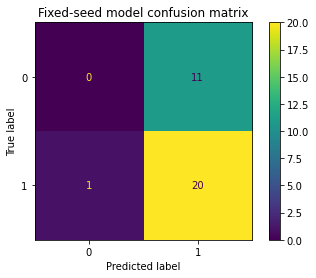

In [19]:
# Making confusion matrix
print(confusion_matrix(y_test.values.argmax(axis=1), y_pred_test.values.argmax(axis=1))) 
# The inputs are converted to binary strings using the argmax along axis 1

# We can also try out another matrix with actual labels, making the confusion matrix less . . . confusing:
ConfusionMatrixDisplay.from_predictions(y_test.values.argmax(axis=1), y_pred_test.values.argmax(axis=1))
plt.title("Fixed-seed model confusion matrix")
plt.show()


How do we interpret the confusion matrix?

- The upper left corner contains the true negatives (correctly rejected negative outcomes).
- The lower left corner contains the false negatives (type 2 errors). 

Since there are four instances in each, the model can be said, with this seed, to be no better than random at prediction true negatives. 
This is a problem since a likely use-case of a replication prediction model would be to flag studies likely to not replicate (is this ability called precision?).

It performs better in predicting positive outcomes: 
- The lower left corner shows the type 1 errors, or false positives. 
- The lower right corner shows the true positives, or hits. 

As evident from the matrix, the larger part of the positive predictions turned out to be true positives.


In [20]:
# Checking the distribution of true positive/negative values in the test set to varify the findings of the confusion matrix: 
print("True positive and negative outcomes in the test set: ", y_test.values.argmax(axis=1))

True positive and negative outcomes in the test set:  [0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0]


### b. Drawing ROC for the classifier, compared to random guess line

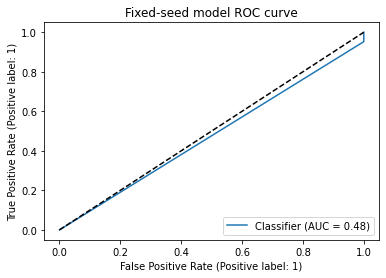

In [22]:
# ROC curve from predictions (looks weird, like a v)
RocCurveDisplay.from_predictions(y_test.values.argmax(axis=1), y_pred_test.values.argmax(axis=1))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("Fixed-seed model ROC curve")
plt.show()


### c. Creating classification report including F1 score

In [24]:
# Printing the classification report to obtain f1-score
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.65      0.95      0.77        21

   micro avg       0.62      0.62      0.62        32
   macro avg       0.32      0.48      0.38        32
weighted avg       0.42      0.62      0.50        32
 samples avg       0.62      0.62      0.62        32



# Training n classifiers and comparing each classifier's accuracy with the dummy classifier
We make n random test train splits, where the 33% of the data is used for testing. For each new split a random forest classifer is trained and both the randomforest model and the dummy models accuracy is tested on the test set. This is done to get an empirical distribution of accuracy scores. The accuracy scores for each iterations are exported to a .csv. 

In [25]:
#empty list of observed accuracies
accuracies = []
dummy_accuracy_list = []

#iterations ### EXPSENSIVE ### 100 iterations is approx 9 sec on M1 Macbook Air
n = 1000

#make a new train-test split and test accuracy
for i in range(n):
    # Make train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    # train model for each iteration
    forest.fit(X_train, y_train)
    # generate predictions
    y_pred_test = forest.predict(X_test)
    # score predicitons
    accuracy = accuracy_score(y_test, y_pred_test)
    # save accurcy score to list
    accuracies.append(accuracy)


    # save dummy list accuracies
    dummy_accuracy_list.append(accuracy_score(y_test, dummy_model_pd))

#turn list of accuracies into dataframe
accuracies_df = pd.DataFrame(list(zip(accuracies, dummy_accuracy_list)), index=None)
accuracies_df.columns = ['accuracy', 'dummy accuracy']

#save to .csv for visualization in r
accuracies_df.to_csv("../data/accuracies.csv")

#print mean scores for the curious
print("Mean trained model accuracy: ",np.mean(accuracies))
print("Mean dummy accuracy: ", np.mean(dummy_accuracy_list))


Mean trained model accuracy:  0.60225
Mean dummy accuracy:  0.6228125
